

## Project 1: CO2, BC Multilevel Discrete Wavelet Transform of 1D Time Series



### Project Objective 
Identify vehicles releasing pollutants, Black Carbon, oxides of nitrogen and GHG (CO2) 
#### Use Disrete Wavelet transform and 1D time series to denoise the signal
- Make multilevel decomposition 
- Visualize the Approximation and Details coeffcients
- Reconstruct orignal time series signal
- Reconstruct the Approximation and Details
- Visualize the Approximation and Details
- reduce data noise at different levels and visualizae the results

### Import required packages

In [1]:
%matplotlib inline
import os
import glob
import csv
import re
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import pywt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from mpl_toolkits.mplot3d import Axes3D 
from scipy import signal
from scipy.signal import find_peaks
from scipy import optimize
from scipy.stats import linregress, stats
import seaborn as sns

import datetime as dt
from textwrap import wrap


# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
os.getcwd()

'C:\\Users\\bina_\\Dropbox\\Robina Shaheen_PEMS2022\\PEMS_NOx_BC_CO2_ALPR\\ii.dwt'

### Read the data

In [2]:
# base_path=os.path.join ('ii.dwt','data')
# base_path
df = pd.read_csv('./data/2022-09-02/licor850.csv')
df.head()


,Time,Cell Temp,Cell Pres,CO2,CO2abs,H2O,H2O abs,H2O Dewpoint,Flow Rate
0,2022-09-02 00:00:01.237598,51.5784,99.0127,374.266,0.082823,19.9547,0.112372,17.2515,0.723401
1,2022-09-02 00:00:02.237697,51.5767,99.0116,372.722,0.082802,19.9811,0.112460,17.2722,0.724015
2,2022-09-02 00:00:03.237298,51.5751,99.0130,375.533,0.083083,19.9961,0.112603,17.2843,0.723789
3,2022-09-02 00:00:04.237394,51.5734,99.0099,376.521,0.083673,20.0289,0.112620,17.3097,0.724029
4,2022-09-02 00:00:05.237493,51.5717,99.0124,377.972,0.083499,20.0316,0.112659,17.3122,0.724058


In [3]:
print(df.columns)
print(df.shape)
df = df.ffill().bfill()
df.info()

Index(['Time', 'Cell Temp', 'Cell Pres', 'CO2', 'CO2abs', 'H2O', 'H2O abs',
       'H2O Dewpoint', 'Flow Rate'],
      dtype='object')
(71054, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71054 entries, 0 to 71053
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Time          71054 non-null  object 
 1   Cell Temp     71054 non-null  float64
 2   Cell Pres     71054 non-null  float64
 3   CO2           71054 non-null  float64
 4   CO2abs        71054 non-null  float64
 5   H2O           71054 non-null  float64
 6   H2O abs       71054 non-null  float64
 7   H2O Dewpoint  71054 non-null  float64
 8   Flow Rate     71054 non-null  float64
dtypes: float64(8), object(1)
memory usage: 4.9+ MB


In [4]:
print('Empty cells/ zero values:', df.isnull().sum())

Empty cells/ zero values: Time            0
Cell Temp       0
Cell Pres       0
CO2             0
CO2abs          0
H2O             0
H2O abs         0
H2O Dewpoint    0
Flow Rate       0
dtype: int64


In [5]:
df['time2'] = df['Time'].astype(str).str.split().str[1]
df.head(2)

,Time,Cell Temp,Cell Pres,CO2,CO2abs,H2O,H2O abs,H2O Dewpoint,Flow Rate,time2
0,2022-09-02 00:00:01.237598,51.5784,99.0127,374.266,0.082823,19.9547,0.112372,17.2515,0.723401,00:00:01.237598
1,2022-09-02 00:00:02.237697,51.5767,99.0116,372.722,0.082802,19.9811,0.112460,17.2722,0.724015,00:00:02.237697


### Visualize CO2 Data/Signal

In [6]:
df2 = pd.DataFrame(df,
                  columns=['time2', 'CO2'])
df2.head(3)

,time2,CO2
0,00:00:01.237598,374.266
1,00:00:02.237697,372.722
2,00:00:03.237298,375.533


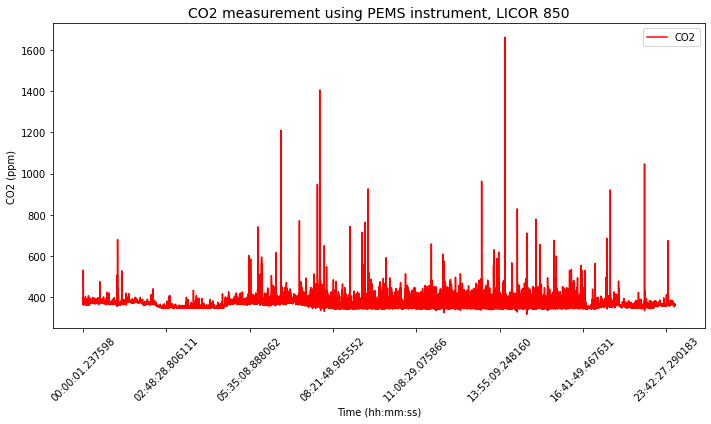

In [7]:
# set plot size for the plot
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"

plt.rcParams["figure.figsize"] = (10, 6)
offset = -.03


df2.plot(x='time2', y='CO2',color="red")

# plt.setp(ax.get_xticklabels(), rotation=45)
# Define the date format
# format your data to desired format. 

#import matplotlib.dates as mdates
# #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# date_form = DateFormatter("%M:%S")
# ax.xaxis.set_major_formatter(date_form)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel('CO2 (ppm)')
plt.xlabel('Time (hh:mm:ss)')
plt.title("CO2 measurement using PEMS instrument, LICOR 850", fontsize=14)
plt.tight_layout()
plt.savefig('./Results2/CO2_PEMS.png',dpi=300)
plt.show()

In [8]:
df_stat = df2[['CO2']].agg(['min','max', 'mean'])
print (df_stat)

              CO2
min    316.682000
max   1662.770000
mean   367.387431


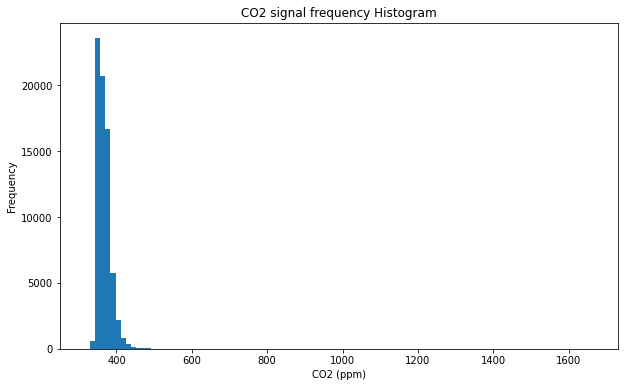

In [9]:
x= df2['CO2']
plt.hist(x, bins = 100)
plt.gca().set(title='CO2 signal frequency Histogram', 
              xlabel= 'CO2 (ppm)', ylabel='Frequency');

### Slice  data for wavelet transformations

In [10]:
t = df['time2']
s = df['CO2']
t

0        00:00:01.237598
1        00:00:02.237697
2        00:00:03.237298
3        00:00:04.237394
4        00:00:05.237493
              ...       
71049    23:59:56.292357
71050    23:59:57.292257
71051    23:59:58.295455
71052    23:59:59.295354
71053    00:00:00.295251
Name: time2, Length: 71054, dtype: object

### (4) Plot the signal using index values instead of time stamps

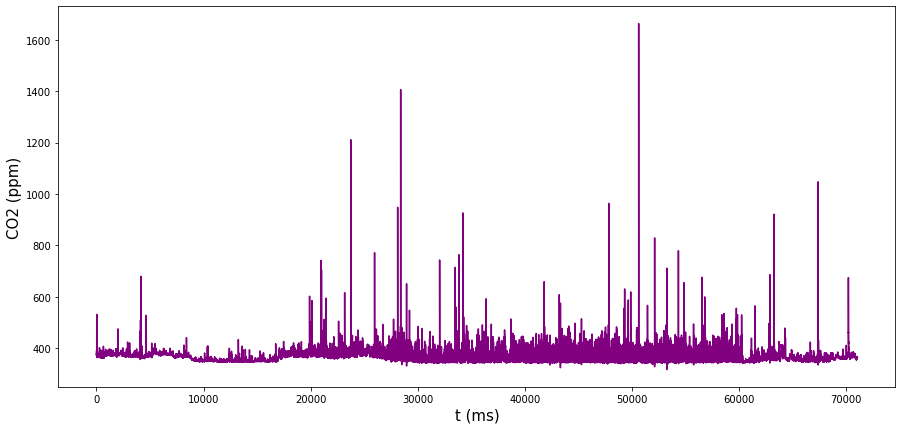

In [11]:
fig,ax = plt.subplots(figsize=(15,7))

plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)

# ax.plot(t,s)
# Add x-axis and y-axis
ax.plot(df.index.values,
       df['CO2'],
       color='purple')
ax.set_xlabel('t (ms)',fontsize=15)
ax.set_ylabel('CO2 (ppm)',fontsize=15)

plt.savefig('./Results2/CO2_indexed_PEMS.png',dpi=300)
plt.show()

## 4. Perform Multi-level Wavelet Decomposition

### (1) Maximum decomposition level

In [12]:
w = pywt.Wavelet('db6')
l = len(s)
f_l = w.dec_len

max_l = pywt.dwt_max_level(data_len=l, filter_len=f_l)

print(max_l)
print(l)

12
71054


### (2) Wavelet decomposition

In [13]:

coeffs = pywt.wavedec(s,'db6','sym',level=6)

(cA6,cD6,cD5,cD4,cD3,cD2,cD1) = coeffs

### (3) Print the approximation and detail coefficients

In [14]:
print('cA6 = ',cA6)
print('cD6 = ',cD6)

cA6 =  [3009.63412893 3001.72864156 3002.06893587 ... 2908.7022425  2898.49613201
 2902.28899853]
cD6 =  [  0.02832321  -0.24412217   0.45699413 ...  23.50010081 -15.26029438
 -14.28217499]


### (3) length of the coefficients 

In [15]:
print(len(s))
print(len(cA6))
print(len(cD6))

71054
1121
1121


## 5. Visualization of  Approximation and Details Coefficients

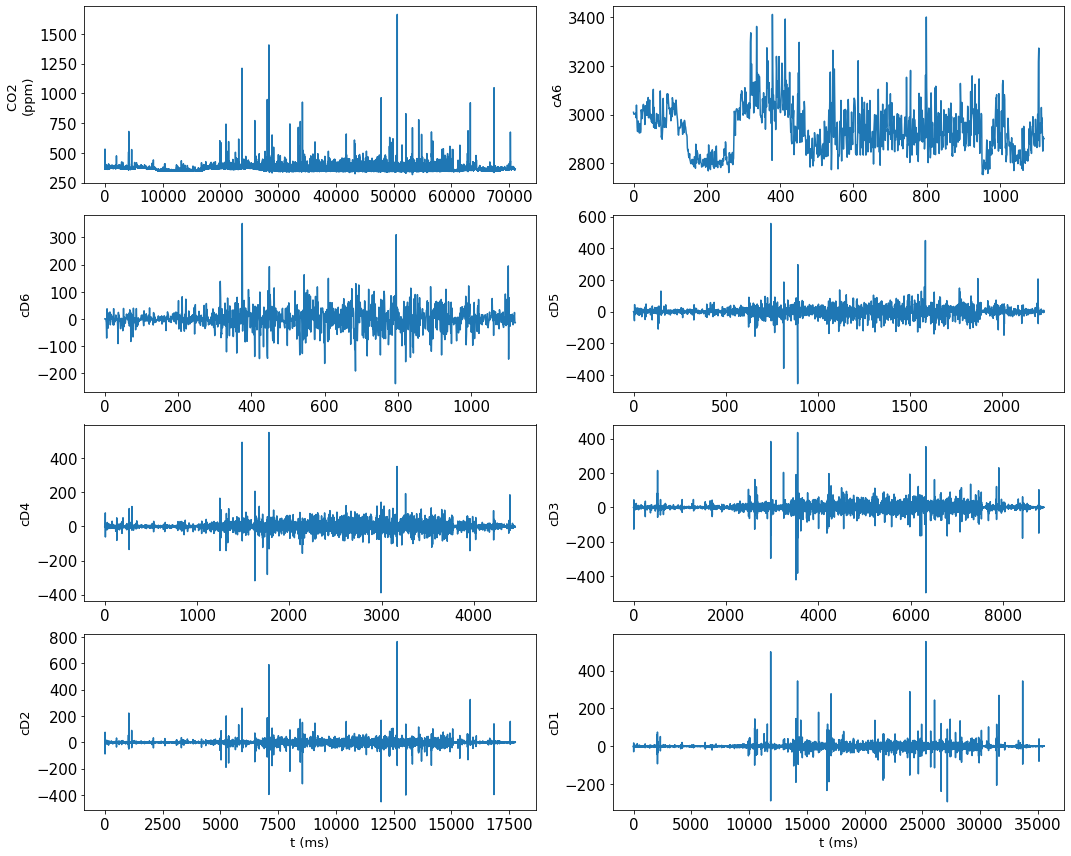

In [16]:
fig,axs = plt.subplots(4,2,figsize=(15,12))

plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

axs[0,0].plot(s)
axs[0,0].set_ylabel('CO2 \n(ppm)',fontsize=13)

axs[0,1].plot(cA6)
axs[0,1].set_ylabel('cA6',fontsize=13)

axs[1,0].plot(cD6)
axs[1,0].set_ylabel('cD6',fontsize=13)

axs[1,1].plot(cD5)
axs[1,1].set_ylabel('cD5',fontsize=13)

axs[2,0].plot(cD4)
axs[2,0].set_ylabel('cD4',fontsize=13)

axs[2,1].plot(cD3)
axs[2,1].set_ylabel('cD3',fontsize=13)

axs[3,0].plot(cD2)
axs[3,0].set_ylabel('cD2',fontsize=13)
axs[3,0].set_xlabel('t (ms)',fontsize=13)

axs[3,1].plot(cD1)
axs[3,1].set_ylabel('cD1',fontsize=13)
axs[3,1].set_xlabel('t (ms)',fontsize=13)

plt.tight_layout()
plt.savefig('./Results2/CO2_s_coeffs.png',dpi=300)

plt.show()

## 6. Reconstruct the Signal

In [17]:
s_r = pywt.waverec(coeffs,'db6','sym')
s_r



array([374.266, 372.722, 375.533, ..., 361.886, 362.748, 363.025])

In [18]:
df3= pd.DataFrame(s_r,columns=['recon_s'] )
# df3
# df3.rename(columns={'0':'s_r'}, inplace=True)
df3
# combined_sig = pd.concat([df3, df2])
# combined_sig

,recon_s
0,374.266
1,372.722
2,375.533
3,376.521
4,377.972
...,...
71049,362.200
71050,362.291
71051,361.886
71052,362.748


In [19]:
print(len(s))
print(len(s_r))

71054
71054


### (3) Comparing reconstructed signal with the original one to ensure reproducibility of data

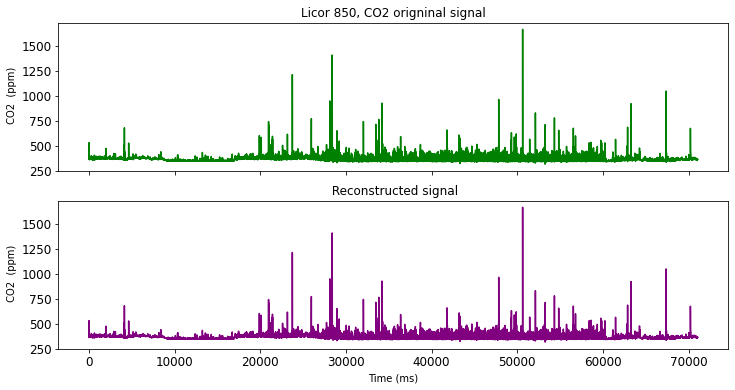

In [20]:
# plot
fig,(ax1,ax2) = plt.subplots(2,1, sharex= True, figsize=(12,6))
# Add x-axis and y-axis
ax1.plot(df3.index.values,
       df3['recon_s'],
       color='green')
ax2.plot(df.index.values,
       df['CO2'],
       color='purple')
ax1.set(
    ylabel=" CO2  (ppm)",
    title="Licor 850, CO2 origninal signal")
ax2.set(xlabel = "Time (ms)",
    ylabel=" CO2  (ppm)",
    title=" Reconstructed signal")
# ax.plot(t,s)
# ax.plot(t,s_r)

plt.show()

## 7. Reconstruct Approximations and Details 

### (1) Create zero arrays

In [21]:
cA06 = np.zeros(len(cA6))
cD06 = np.zeros(len(cD6))
cD05 = np.zeros(len(cD5))
cD04 = np.zeros(len(cD4))
cD03 = np.zeros(len(cD3))
cD02 = np.zeros(len(cD2))
cD01 = np.zeros(len(cD1))

In [22]:
print(cA06)

[0. 0. 0. ... 0. 0. 0.]


### (2) Reconstruct Approximations and Details

In [23]:
A6 = pywt.waverec((cA6,cD06,cD05,cD04,cD03,cD02,cD01),'db6','sym')
D6 = pywt.waverec((cA06,cD6,cD05,cD04,cD03,cD02,cD01),'db6','sym')
D5 = pywt.waverec((cA06,cD06,cD5,cD04,cD03,cD02,cD01),'db6','sym')
D4 = pywt.waverec((cA06,cD06,cD05,cD4,cD03,cD02,cD01),'db6','sym')
D3 = pywt.waverec((cA06,cD06,cD05,cD04,cD3,cD02,cD01),'db6','sym')
D2 = pywt.waverec((cA06,cD06,cD05,cD04,cD03,cD2,cD01),'db6','sym')
D1 = pywt.waverec((cA06,cD06,cD05,cD04,cD03,cD02,cD1),'db6','sym')

In [24]:
# check the length

print(len(s))
print(len(A6))

71054
71054


In [25]:
app6= pd.DataFrame(A6,columns=['Approx_6'] )
app6
app6.to_csv('./data/CO2_denoised_app6_signal.csv',index=False)

### (3) Approximations at other levels

In [26]:
A5 = A6 + D6 
A4 = A6 + D6 + D5
A3 = A6 + D6 + D5 + D4
A2 = A6 + D6 + D5 + D4 + D3
A1 = A6 + D6 + D5 + D4 + D3 + D2

### (4) Reconstruct signal from approximation and details

In [27]:
s_r = A6 + D6 + D5 + D4 + D3 + D2 + D1

In [28]:
# Reconstructed signal from approximation
app3_CO2= pd.DataFrame(A3,columns=['Approx_3'] )
app3_CO2
app2= pd.DataFrame(A2,columns=['Approx_2'] )
app2

,Approx_2
0,373.320520
1,373.535384
2,374.199796
3,374.838103
4,375.600874
...,...
71049,362.303035
71050,362.311213
71051,362.385422
71052,362.529105


In [ ]:
# BC = pd.read_csv('./data/IR_BC1_ug_denoised_recon_s3_t.csv')
# BC.rename(columns={'Approx_3':'BC_app_3'}, inplace=True)
# BC.head(3)

## 8. Visualization of Approximation and Details

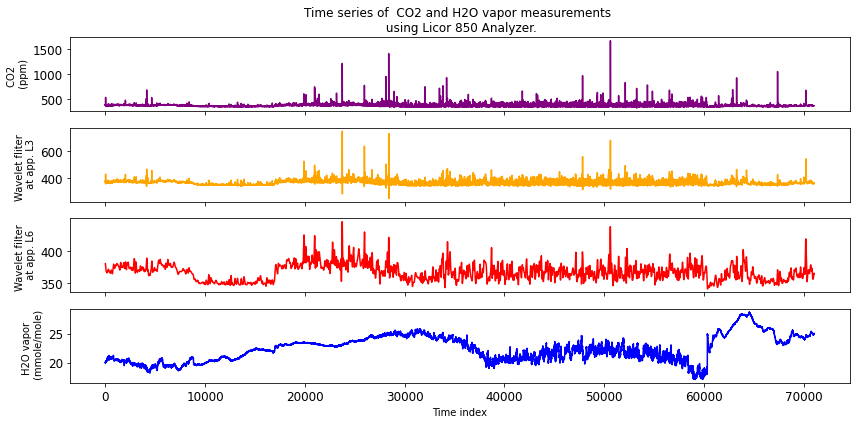

In [29]:
fig, (ax1, ax2, ax3, ax4,) = plt.subplots(4, 1, 
                    sharex=True, figsize=(12, 6))
# Add x-axis and y-axis
ax1.plot(df.index.values,
         df['CO2'],
         color='purple')
# ax2.plot(app2.index.values,
#        app2['Approx_2'],
#        color='orange')

ax2.plot(app3_CO2.index.values,
         app3_CO2['Approx_3'],
         color='orange')
ax3.plot(app6.index.values,
         app6['Approx_6'],
         color='red')
ax4.plot(df.index.values,
         df['H2O'],
         color='blue')
# ax5.plot(BC.index.values,
#          BC['BC_app_3'],
#          color='black')

ax1.set(
    ylabel=" CO2  \n (ppm)",
    title="Time series of  CO2 and H2O vapor measurements \n using Licor 850 Analyzer.")
# ax2.set(ylabel=" App. L2")
ax2.set(ylabel="Wavelet fliter \n at app. L3")
ax3.set(ylabel="Wavelet filter \n at app. L6")
ax4.set(xlabel = 'Time index',
        ylabel="H2O vapor \n (mmole/mole)")
# ax5.set(ylabel="BC (ug/m3)")
# ax = plt.gca().legend(('original measurements'))
# ax1.legend('original measurements',loc = 'upper left')
plt.tight_layout()
plt.savefig('./Results2/CO2_denoised_signal_H2O_comparisonb.png')
plt.show()

### (1) Reconstruct the approximations

In [30]:
A5 = A6 + D6 
A4 = A6 + D6 + D5
A3 = A6 + D6 + D5 + D4
A2 = A6 + D6 + D5 + D4 + D3
A1 = A6 + D6 + D5 + D4 + D3 + D2

### (3) Peak detection using Scipy

In [31]:
import matplotlib.pyplot as plt
# from scipy.misc import electrocardiogram
from scipy.signal import find_peaks

In [32]:
app6= pd.DataFrame(A6,columns=['Approx_6'] )
app6
df6_s = app6[['Approx_6']].agg(['min','max', 'mean'])
print (df6_s)
print(len(app6))

        Approx_6
min   341.538267
max   444.397474
mean  367.385384
71054


In [33]:
app6_t= pd.concat([app6, t], axis = 1)
# recon_s_t['time'] = recon_s_t['time2'].astype('datetime64[s]')

# app3.to_csv('./data/IR_BC1_ug_denoised_signal.csv',index=False)
app6_t.to_csv('./Results2/CO2_ppm_denoised_recon_s6_t.csv',index=True)
print(len(app6_t))
app6_t.head()

71054


,Approx_6,time2
0,380.262333,00:00:01.237598
1,380.194802,00:00:02.237697
2,380.116353,00:00:03.237298
3,380.028352,00:00:04.237394
4,379.931131,00:00:05.237493


In [34]:
# peak_date=recon_s_t["time"].values
# print(peak_date)
peak_date6=app6_t["time2"].values
peak_s6=app6_t["Approx_6"].values

x6_array =peak_date6
y6_array= peak_s6
print(y6_array)
print(x6_array)

[380.26233268 380.19480219 380.11635302 ... 365.28362078 365.19025519
 365.09147791]
['00:00:01.237598' '00:00:02.237697' '00:00:03.237298' ...
 '23:59:58.295455' '23:59:59.295354' '00:00:00.295251']


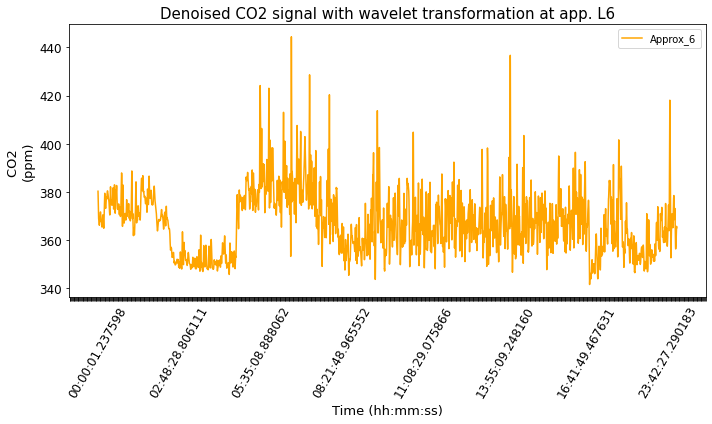

In [36]:
plt.rcParams["figure.figsize"] = (10, 6)
offset = -.03
# df2 = pd.DataFrame(df,
#                   columns=['Time', 'IR BC1_ug'])

app6_t.plot(x='time2', y='Approx_6',color="orange")

plt.xticks(rotation =60)
plt.title("Denoised CO2 signal with wavelet transformation at app. L6",
          fontsize= 15, color = 'black')
plt.ylabel('CO2 \n(ppm)', fontsize= 13)
plt.xlabel('Time (hh:mm:ss)', fontsize = 13)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(100))
plt.tight_layout()
plt.savefig('./Results2/CO2_denoised_A6.png', dpi=300)
plt.show()

In [ ]:

# plt.plot(x6_array, y6_array)
# plt.gca().xaxis.set_major_locator(plt.MultipleLocator(100))
# plt.xticks(rotation =60)
# plt.ylabel('CO2 (ppm)', fontsize= 13)
# plt.xlabel('Time (hh:mm:ss)', fontsize = 13)
# plt.tight_layout()
# plt.show()

In [ ]:
CO2_subset_s6= app6_t[:3000]
print(len(CO2_subset_s6))
print(CO2_subset_s6.head(3))
print(CO2_subset_s6.dtypes)
print(CO2_subset_s6.tail(3))
peak_subset_s6_time2=CO2_subset_s6["time2"].values
print(peak_subset_s6_time2)
# peak_date=recon_s_t["time"].values
# print(peak_date)
peak_subset_s6=CO2_subset_s6["Approx_6"].values
peak_subset_s6

In [ ]:
# # A6s=A6[2800:3000]
# # A6s.shape
# A6s1=A6[1000:3000]
# A6s1.shape
x6_ss_array =peak_subset_s6_time2
# amp1 = 3000
# sigma1 = 10
# cen1 = 50
y6_ss_array= peak_subset_s6


# # A6.sort_index().loc[1700:3000]
# # A6s.shape
# # # s_p=s[1700:3000]
# # # s_p.shape
# # # s_p.ndim
plt.plot(x6_ss_array, y6_ss_array)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(100))
plt.xticks(rotation =60)
plt.ylabel('CO2 at L6 \n(ppm)', fontsize= 13)
plt.xlabel('Time (hh:mm:ss)', fontsize = 13)
plt.tight_layout()
plt.show()

In [39]:
# Reconstructed signal from approximation
app3= pd.DataFrame(A3,columns=['Approx_3'] )
app3
# arr3 = app3.to_numpy()
# arr3
# arr3.dtype
# app2= pd.DataFrame(A2,columns=['Approx_2'] )
# app2
df3_stat = app3[['Approx_3']].agg(['min','max', 'mean'])
print(len(df3_stat))
print(len(app3))
print (df3_stat)

3
71054
        Approx_3
min   248.440564
max   747.582834
mean  367.387537


In [ ]:
# recon_s3_t= pd.concat([app3, t], axis = 1)
# # recon_s_t['time'] = recon_s_t['time2'].astype('datetime64[s]')

# # app3.to_csv('./data/IR_BC1_ug_denoised_signal.csv',index=False)
# recon_s3_t.to_csv('./data/CO2_ppm_denoised_recon_s3_t.csv',index=False)
# print(len(recon_s3_t))
# recon_s3_t.head()
# # df_s = recon_s_t[['Approx_3']].agg(['min','max'])
# # print (df_s)

In [ ]:
# CO2 diurnal variations 380-500 ppm in arizona and traffic
# Check Scipy package to extract features of peaks
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 6))
# x = A3
# peaks, _ = find_peaks(x, height=400)
# plt.plot(x)
# plt.plot(peaks, x[peaks], "x")
# plt.axhline(350, linestyle='--',color="gray" )
# ax.set(xlabel= "Time",
#     ylabel=" CO2  (ppm)",
#     title="CO2 peak identification after removing instrumental noise")
# plt.show()

In [ ]:
# at approximation level 3
from scipy import signal
sig_peaks, _ = signal.find_peaks(A)
promin = signal.peak_prominences(A3, sig_peaks)[1]
#promin

In [ ]:
# plt.plot(A6)
# plt.plot(sig_peaks, A6[sig_peaks], "*")
# plt.hlines(*half_peak_res[1:], color = 'C4')
# plt.hlines(*full_peak_res[1:], color = 'C6')
# plt.show()

In [ ]:
# contur_height = A6[sig_peaks] - promin
# plt.plot(A6)
# plt.plot(sig_peaks, A6[sig_peaks], "*")
# plt.vlines(x=sig_peaks, ymin=contur_height, ymax=A6[sig_peaks])
# plt.show()

In [ ]:
# A6s=A6[2800:3000]
# A6s.shape
# y_array= A6s


# # # A6.sort_index().loc[1700:3000]
# # # A6s.shape
# # # # s_p=s[1700:3000]
# # # # s_p.shape
# # # # s_p.ndim
# plt.plot(x_array, y_array)

In [ ]:
# take slice of data
CO2_subset_s6= app6_t[:3000]
print(len(CO2_subset_s6))
print(CO2_subset_s6.head(3))
print(CO2_subset_s6.dtypes)
CO2_subset_s6.tail(3)


In [ ]:
CO2_subset_s6_stat= CO2_subset_s6[['Approx_6']].agg(['min',
                                                      'max', 'mean'])
print (CO2_subset_s6_stat)
#Full dataset       Approx_3
# min   248.440564
# max   747.582834
# mean  367.387537

In [ ]:
x3_array = peak_s3_time2
# amp1 = 3000
# sigma1 = 10
# cen1 = 50
y3_array= peak_s3_sig

In [ ]:
plt.plot(x6_array, y6_array, color= 'g')
plt.xticks(rotation =60) # Rotates X-Axis Ticks by 45-degrees
plt.grid(b=True, which='major', color='grey', linestyle='--')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1000))
plt.show()

In [ ]:
# sig_peaks, _ = signal.find_peaks(A3)
# promin = signal.peak_prominences(A3, sig_peaks)[1]

In [ ]:
# # x_array = np.arange(1000,3000)
# # amp1 = 3000
# # sigma1 = 10
# # cen1 = 50
# y_array= A6s1


# # A6.sort_index().loc[1700:3000]
# # A6s.shape
# # # s_p=s[1700:3000]
# # # s_p.shape
# # # s_p.ndim
# plt.plot(x_array, y_array)

In [ ]:
# sig_peaks, _ = signal.find_peaks(A)
# promin = signal.peak_prominences(A3, sig_peaks)[1]

In [43]:
peaks, properties = find_peaks(y6_array, prominence=10, width=20)
sig_peaks, _ = signal.find_peaks(y6_array)
promin = signal.peak_prominences(y6_array, sig_peaks)[0]
print(len(promin))
# promin

486


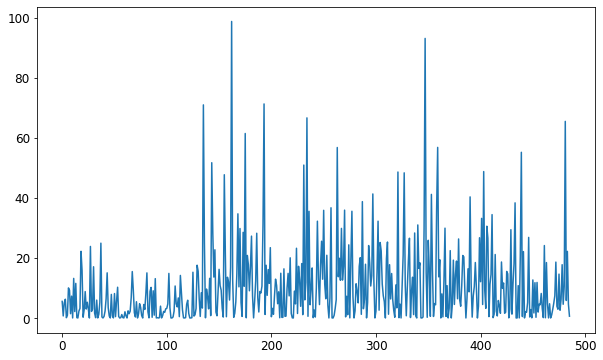

In [44]:
plt.plot(promin)

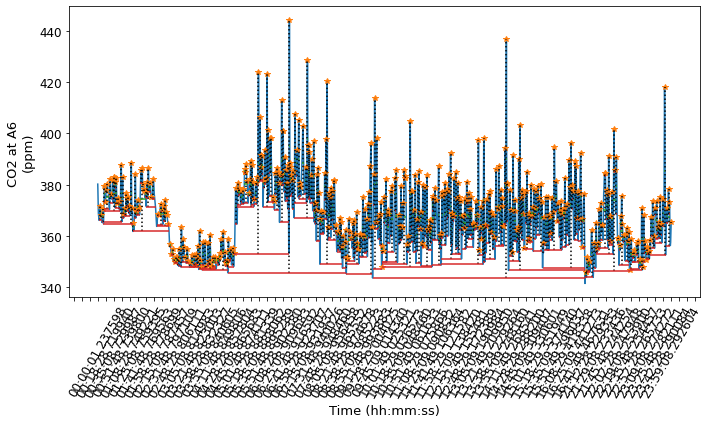

In [45]:
half_peak_res = signal.peak_widths(y6_array, sig_peaks, rel_height = .5)
full_peak_res = signal.peak_widths(y6_array, sig_peaks, rel_height = 1)


plt.plot(x6_array, y6_array)
plt.plot(sig_peaks, y6_array[sig_peaks], "*")
contur_height = y6_array[sig_peaks] - promin
# plt.plot(y_array)
# plt.plot(sig_peaks, y_array[sig_peaks], "*")
plt.vlines(x=sig_peaks, ymin=contur_height, ymax=y6_array[sig_peaks], 
           color ='black', linestyle='dotted')
plt.hlines(*half_peak_res[1:], color = 'C12')
plt.hlines(*full_peak_res[1:], color = 'C3')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1000))
plt.xticks(rotation =60)
plt.ylabel('CO2 at A6 \n(ppm)' , fontsize= 13)
plt.xlabel('Time (hh:mm:ss)', fontsize = 13)
plt.tight_layout()
plt.savefig('./Results2/CO2_peak_area_s6_height.png')
plt.show()

In [ ]:
# peaks, properties = find_peaks(y3_array, prominence=2, width=10)
# sig_peaks, _ = signal.find_peaks(y3_array)
# promin = signal.peak_prominences(y3_array, sig_peaks)[0]
# print(len(promin))


In [ ]:
# plt.plot(promin)

In [ ]:
half_peak_res = signal.peak_widths(y3_array, sig_peaks, rel_height = .5)
full_peak_res = signal.peak_widths(y3_array, sig_peaks, rel_height = 1)


plt.plot(x3_array, y3_array)
plt.plot(sig_peaks, y3_array[sig_peaks], "*")
contur_height = y3_array[sig_peaks] - promin
# plt.plot(y_array)
# plt.plot(sig_peaks, y_array[sig_peaks], "*")
plt.vlines(x=sig_peaks, ymin=contur_height, ymax=y3_array[sig_peaks], 
           color ='black', linestyle='dotted')
plt.hlines(*half_peak_res[1:], color = 'C12')
plt.hlines(*full_peak_res[1:], color = 'C3')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(100))
plt.xticks(rotation =60)
plt.ylabel('CO2 (ppm)', fontsize= 13)
plt.xlabel('Time (hh:mm:ss)', fontsize = 13)
plt.tight_layout()
plt.savefig('./Results2/CO2_peak_area_s3_subset.png')
plt.show()

In [46]:
print('Half width of peaks:', half_peak_res[0])
HWpeak = np.asarray(half_peak_res)
HWpeak_CO2 = pd.DataFrame(HWpeak)
print(HWpeak_CO2.head(3))
HWpeak_CO2.to_csv('./Results2/CO2_s6_HWpeak.csv', index= False)

print('Full width of peaks:', full_peak_res[0])
FWpeak = np.asarray(full_peak_res)
FWpeak_CO2 = pd.DataFrame(FWpeak)
FWpeak_CO2.to_csv('./Results2/CO2_s6_FWpeak.csv')
print('Height of peaks:',contur_height)
contur_height_CO2 = pd.DataFrame(contur_height)
contur_height_CO2.to_csv('./Results2/CO2_s6_peak_height.csv')
# contur_height.to_csv('./results/CO2_peaklength.csv')
print(len(contur_height))
print(len(half_peak_res))
print(type(half_peak_res))
print(type(full_peak_res))
print(type(HWpeak))
print(type(FWpeak))
print(type(contur_height))

Half width of peaks: [1.26247273e+02 3.85266288e+01 1.13538243e+02 6.91303481e+01
 1.13396287e+01 3.12152188e+01 3.69306691e+02 7.25521638e+01
 4.55719349e+01 8.07879915e+01 6.12655555e+00 1.26661618e+02
 3.42629026e+01 1.93162365e+02 1.37180933e+01 4.17651749e+00
 7.41547690e+01 6.22075132e+01 1.31211457e+02 6.78512557e+01
 1.26952788e+01 1.09942565e+02 7.70009968e+01 5.50314329e+01
 7.53069386e+01 5.97844406e+01 1.06196510e+00 9.39328136e+01
 3.08682021e+01 5.92055826e+01 8.68726099e+01 5.28002634e+01
 7.30112481e+00 8.94710470e+01 5.81349451e+00 7.82338943e+01
 8.99318247e+01 7.36831123e+02 1.84610126e+01 2.04488373e+00
 4.12626897e+01 6.25254293e+01 6.76548499e+01 1.12622704e+02
 9.33433325e+01 5.49064318e+01 5.68764601e+00 1.40247198e+02
 9.07983687e+01 1.69008971e+01 3.02156168e+02 4.16188321e+01
 1.44326784e+02 1.10609757e+02 2.50868085e+01 2.91456493e+00
 3.34870189e+01 9.36489503e+01 2.06896920e+01 9.93648508e+00
 6.91690480e+01 5.05682119e+01 2.50838892e+00 1.19434311e+02
 5.

In [ ]:
peak_s6_time2=app6_t["time2"].values
print(peak_s6_time2)
# peak_date=recon_s_t["time"].values
# print(peak_date)
peak_sig6=app6_t["Approx_6"].values
peak_sig6
# x6_array =peak_s6_time2
x6_array= peak_s6_time2
print(x6_array)
# amp1 = 3000
# sigma1 = 10
# cen1 = 50
y6_array= peak_sig6
print(y6_array)

In [ ]:
#_check peak properties with width and prominence.
peaks, properties = find_peaks(y6_array, prominence=2, width=10)
properties["prominences"], properties["widths"]
print(len('widths'))
print(len('prominences'))

In [ ]:


plt.plot(x6_array, y6_array)
plt.plot(sig_peaks, y6_array[sig_peaks], "*")
# plt.vlines(x=peaks, ymin=x[peaks] - properties["prominences"],
#            ymax = x[peaks], color = "C7")
plt.vlines(x=sig_peaks, ymin=contur_height, ymax=y6_array[sig_peaks], 
           color ='black', linestyle='dotted')
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color = "C9")

# plt.vlines(x=sig_peaks, ymin=contur_height, ymax=y6_array[sig_peaks], 
#            color ='black', linestyle='dotted')
plt.hlines(*half_peak_res[1:], color = 'C12')
plt.hlines(*full_peak_res[1:], color = 'C3')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1000))
plt.xticks(rotation =60)
plt.show()

In [ ]:
# peakind = signal.find_peaks_cwt(data, np.arange(1,10))
# peakind, xs[peakind], data[peakind] 

In [ ]:
A6s=A6
A6s.shape

In [ ]:
x1_array = np.arange(0,71054)

y1_array= A6s


# A6.sort_index().loc[1700:3000]
# A6s.shape
# # s_p=s[1700:3000]
# # s_p.shape
# # s_p.ndim
plt.plot(x1_array, y1_array)

In [ ]:
peaks, properties = find_peaks(y6_array, prominence=2, width=10)
sig_peaks, _ = signal.find_peaks(y6_array)
promin = signal.peak_prominences(y6_array, sig_peaks)[0]
print(len(promin))
# promin
plt.plot(promin)

In [ ]:
half_peak_res = signal.peak_widths(y6_array, sig_peaks, rel_height = 0.5)
full_peak_res = signal.peak_widths(y6_array, sig_peaks, rel_height = 1)


plt.plot(x6_array,y6_array)
plt.plot(sig_peaks, y6_array[sig_peaks], "*")
contur_height = y6_array[sig_peaks] - promin
# plt.plot(y_array)
# plt.plot(sig_peaks, y_array[sig_peaks], "*")
plt.vlines(x=sig_peaks, ymin=contur_height, ymax=y6_array[sig_peaks], 
           color ='black', linestyle='dotted')
plt.hlines(*half_peak_res[1:], color = 'C12')
plt.hlines(*full_peak_res[1:], color = 'C3')
plt.savefig('./Results2/full_CO2_peak_area_height.png')
plt.show()

In [48]:
print('Half width of peaks:', half_peak_res[0])
HWpeak = np.asarray(half_peak_res)
HWpeak_CO2 = pd.DataFrame(HWpeak)
# print(HWpeak_CO2.head(3))
HWpeak_CO2.to_csv('./Results2/full_CO2_HWpeak.csv')

print('Full width of peaks:', full_peak_res[0])
FWpeak = np.asarray(full_peak_res)
FWpeak_CO2 = pd.DataFrame(FWpeak)
FWpeak_CO2.to_csv('./Results2/full_CO2_FWpeak.csv')
print('Height of peaks:',contur_height)
contur_height_CO2 = pd.DataFrame(contur_height)
contur_height_CO2.to_csv('./Results2/full_CO2_peak_height.csv')
# contur_height.to_csv('./results/CO2_peaklength.csv')
print(len(contur_height))
print(len(half_peak_res[0]))
print(type(half_peak_res))
print(type(full_peak_res))
print(type(HWpeak))
print(type(FWpeak))
print(type(contur_height))

Half width of peaks: [1.26247273e+02 3.85266288e+01 1.13538243e+02 6.91303481e+01
 1.13396287e+01 3.12152188e+01 3.69306691e+02 7.25521638e+01
 4.55719349e+01 8.07879915e+01 6.12655555e+00 1.26661618e+02
 3.42629026e+01 1.93162365e+02 1.37180933e+01 4.17651749e+00
 7.41547690e+01 6.22075132e+01 1.31211457e+02 6.78512557e+01
 1.26952788e+01 1.09942565e+02 7.70009968e+01 5.50314329e+01
 7.53069386e+01 5.97844406e+01 1.06196510e+00 9.39328136e+01
 3.08682021e+01 5.92055826e+01 8.68726099e+01 5.28002634e+01
 7.30112481e+00 8.94710470e+01 5.81349451e+00 7.82338943e+01
 8.99318247e+01 7.36831123e+02 1.84610126e+01 2.04488373e+00
 4.12626897e+01 6.25254293e+01 6.76548499e+01 1.12622704e+02
 9.33433325e+01 5.49064318e+01 5.68764601e+00 1.40247198e+02
 9.07983687e+01 1.69008971e+01 3.02156168e+02 4.16188321e+01
 1.44326784e+02 1.10609757e+02 2.50868085e+01 2.91456493e+00
 3.34870189e+01 9.36489503e+01 2.06896920e+01 9.93648508e+00
 6.91690480e+01 5.05682119e+01 2.50838892e+00 1.19434311e+02
 5.

In [ ]:
contur_height = y_array[sig_peaks] - promin
plt.plot(y_array)
plt.plot(sig_peaks, y_array[sig_peaks], "*")
plt.vlines(x=sig_peaks, ymin=contur_height, ymax=y_array[sig_peaks],
           color= 'C4')
plt.show()

In [ ]:
data1 = pd.DataFrame({'x':x_array, 'y':y_array})

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(1, 2) # Create subplots
fig.set_figheight(5), fig.set_figwidth(8) # Alter figure size

# Create subplot on first axis, axis[0]
sns.boxplot(ax=axes[0], data=data1['x']).set(title='x') 

# Remove ticks and labels of X axis since they're meaningless
axes[0].tick_params(bottom=False)
axes[0].set(xticklabels=[])

# Repeat for y data
sns.boxplot(ax=axes[1], data=data1['y']).set(title='y')
axes[1].tick_params(bottom=False)
axes[1].set(xticklabels=[])

fig.suptitle('Boxplots using Seaborn to Detect Outliers', fontsize=16) # Add title

In [ ]:
import scipy as scipy
from scipy import optimize
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker
%matplotlib inline

# # linearly spaced x-axis of 10 values between 1 and 10
# x_array = np.linspace(1,100,50)
# plt.plot(A6s)
fig = plt.figure(figsize=(6,3))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])
x_array = np.arange(2800,3000)
# amp1 = 3000
# sigma1 = 10
# cen1 = 50
y_array_gauss= A6s
ax1.plot(x_array, y_array_gauss, "ro")
ax1.xaxis.set_minor_locator(AutoMinorLocator(1))
ax1.yaxis.set_minor_locator(AutoMinorLocator(1))


ax1.tick_params(axis='both',which='major', direction="out", 
                 bottom="on", length=10, labelsize=8)
# ax1.tick_params(axis='both',which='minor', direction="out", top="on", 
#                 right="on", bottom="on", length=10, labelsize=8)

fig.tight_layout()
# plt.plot(os_p)


In [ ]:
data = pd.DataFrame({'x':x, 'y':new_y})

In [ ]:
def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x_array-cen1)/sigma1)**2)))

In [ ]:
popt = np.zeros((np.shape(df)[1],3))
pcov = np.zeros((np.shape(df)[1],3,3))
perr = np.zeros((np.shape(df)[1],3))
pars = np.zeros((popt.shape[0],3))
peak = np.zeros((popt.shape[0],np.shape(df)[0]))

In [ ]:
popt_gauss, pcov_gauss = scipy.optimize.curve_fit(_1gaussian, x_array, y_array_gauss, p0=[amp1, cen1, sigma1])

perr_gauss = np.sqrt(np.diag(pcov_gauss))

In [ ]:
# this cell prints the fitting parameters with their errors
print("amplitude = %0.2f (+/-) %0.2f" % (popt_gauss[0], perr_gauss[0]))
print("center = %0.2f (+/-) %0.2f" % (popt_gauss[1], perr_gauss[1]))
print("sigma = %0.2f (+/-) %0.2f" % (popt_gauss[2], perr_gauss[2]))